In [1]:
import re
import string
import json
import csv
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
direc = 'Week_7'
with open(f'{direc}/important_words.json') as f:
    important_words = json.load(f)
with open(f'{direc}/amazon_baby_subset.csv') as f:
    products = pd.read_csv(f)
with open(f'{direc}/module-10-assignment-validation-idx.json') as f:
    validation_idx = json.load(f)
with open(f'{direc}/module-10-assignment-train-idx.json') as f:
    train_idx = json.load(f)

In [3]:
products

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1
...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1


# Data Cleaning Process

In [4]:
def remove_punctuation(text):
    trans = str.maketrans('','',string.punctuation)
    return text.translate(trans)

In [5]:
products = products.fillna({'review':''})
products['review_clean'] = products['review'].apply(remove_punctuation)

In [6]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [ ]:
#products['sentiment'] = products['rating'].apply(lambda x: +1 if x > 3 else -1)

In [7]:
def get_numpy_data(data, features, target):
    data['constant'] = 1.
    extracted_data = data[['constant'] + features]
    extracted_label = data[target]
    converted_data = extracted_data.to_numpy()
    converted_label = extracted_label.to_numpy()
    return (converted_data, converted_label)

In [8]:
train_data = products.iloc[train_idx]
validation_data = products.iloc[validation_idx]

In [9]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

Quiz Q1:
In Module 3 assignment, there were 194 features (an intercept + one feature for each of the 193 important words). In this assignment, we will use stochastic gradient ascent to train the classifier using logistic regression. How does the changing the solver to stochastic gradient ascent affect the number of features?

# Logistic Regression from scratch

In [10]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1. / (1. + np.exp(-score))
    
    # return predictions
    return predictions

In [11]:
def feature_derivative(errors, feature):     
   
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
        # Return the derivative
    
    return derivative

In [22]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    """
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    #lp = np.sum(np.subtract(np.array((indicator-1)*scores), np.log(1. + np.exp(-scores))))
    
    ev = np.multiply((indicator-1.), scores)
    nv = np.log(1. + np.exp(-scores))
    
    lp = np.sum(np.subtract(ev, nv))
    """
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask] 
    
    indi_score = np.multiply((indicator - 1.), scores)
    log_likelihood = np.subtract(indi_score, logexp)
    
    lp = np.sum(log_likelihood)/len(feature_matrix)   
    

    return lp

Quiz question: Recall from the lecture and the earlier assignment, the log likelihood (without the averaging term) is given by

How are the functions \ell\ell(\mathbf{w})ℓℓ(w) and \ell\ell_A(\mathbf{w})ℓℓ A​	(w) related?

In [13]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print ("Gradient single data point: %s" % gradient_single_data_point)
print ("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


Quiz Question: The code block above computed the derivative

The code block above computed the derivative \partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}∂ℓ 
i​	(w)/∂w_j​	for j = 1 and i = 10.  
Is \partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}∂ℓ 
i​ (w)/∂w_j​	a scalar or a 194-dimensional vector?

In [14]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print ("Gradient mini-batch data points: %s" % gradient_mini_batch)
print ("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


* Create an empty list called log_likelihood_all
* Initialize coefficients to initial_coefficients
* Set random seed = 1
* Shuffle the data before starting the loop below
* Set i = 0, the index of current batch

* Run the following steps max_iter times, performing linear scans over the data:
  * Predict P(y_i = +1|x_i,w) using your predict_probability() function
    Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
  * Compute indicator value for (y_i = +1)
    Make sure to slice the i-th entry with [i:i+batch_size]
  * Compute the errors as (indicator - predictions)
  * For each coefficients[j]:
    - Compute the derivative for coefficients[j] and save it to derivative.
      Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
    - Compute the product of the step size, the derivative, and (1./batch_size).
    - Increment coefficients[j] by the product just computed.
  * Compute the average log likelihood over the current batch.
    Add this value to the list log_likelihood_all.
  * Increment i by batch_size, indicating the progress made so far on the data.
  * Check whether we made a complete pass over data by checking
    whether (i+batch_size) exceeds the data size. If so, shuffle the data. If not, do nothing.

* Return the final set of coefficients, along with the list log_likelihood_all.

In [20]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i: i+batch_size, :], coefficients)

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i: i+batch_size] == +1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i: i + batch_size, j])
            
            # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += step_size * (1./batch_size) * derivative

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
        or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print ('Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % 
                (int(np.ceil(np.log10(max_iter))), itr, 
                 int(np.ceil(np.log10(data_size))), i, 
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

For what value of batch size B above is the stochastic gradient ascent function logistic_regression_SG act as a standard gradient ascent algorithm?

In [26]:
# Checkpoint
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3), step_size=1., batch_size=2, max_iter=2)
print ('-------------------------------------------------------------------------------------')
print ('Coefficients learned                 :', coefficients)
print ('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print ('-------------------------------------------------------------------------------------')
    print ('Test passed!')
else:
    print ('-------------------------------------------------------------------------------------')
    print ('Test failed')

Iteration 0: Average log likelihood (of data points  [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points  [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


In [30]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = 10

In [31]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients, step_size, batch_size, max_iter)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


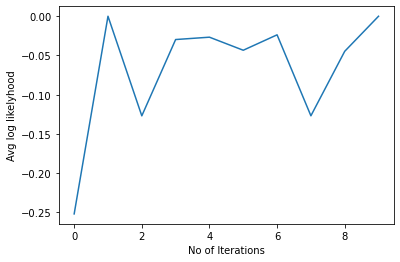

In [32]:
plt.ylabel("Avg log likelyhood")
plt.plot(log_likelihood)
plt.xlabel("No of Iterations")
plt.show()

Quiz Question. When you set batch_size = 1, as each iteration passes, how does the average log likelihood in the batch change?

In [33]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = feature_matrix_train.shape[0]
max_iter = 200

In [34]:
coefficients, log_likelihood  = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients, step_size, batch_size, max_iter)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

Quiz Question. When you set batch_size = len(train_data), as each iteration passes, how does the average log likelihood in the batch change?

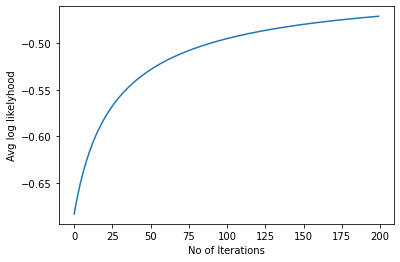

In [36]:
plt.ylabel("Avg log likelyhood")
plt.plot(log_likelihood)
plt.xlabel("No of Iterations")
plt.show()

Quiz Question. When you set batch_size = len(train_data), as each iteration passes, how does the average log likelihood in the batch change?

Quiz Question Suppose that we run stochastic gradient ascent with a batch size of 100. How many gradient updates are performed at the end of two passes over a dataset consisting of 50000 data points?

In [37]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

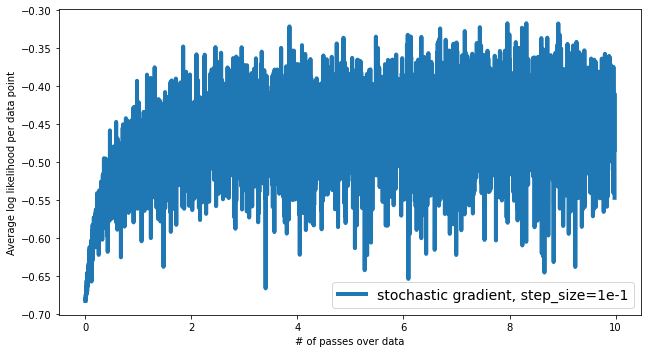

In [38]:
# Log likelihood plots for stochastic gradient ascent
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100, label='stochastic gradient, step_size=1e-1')

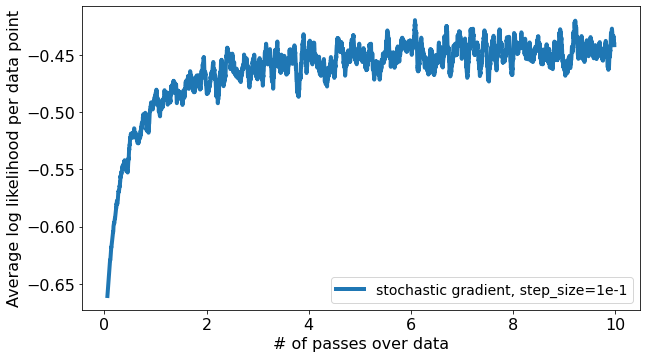

In [39]:

#Smoothing the stochastic gradient ascent curve

make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

In [ ]:
#Stochastic gradient ascent vs batch gradient ascent
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

In [ ]:
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                        initial_coefficients=np.zeros(194),\
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

In [ ]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

In [ ]:

#Explore the effects of step sizes on stochastic gradient ascent
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                       initial_coefficients=np.zeros(194),\
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

In [ ]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

In [ ]:

for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)